## NBC Region: Speed in sigma range & top 1000m EKE 

In [69]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [70]:
### function to fix non-monotonic longitude
def fix_orca_longitude(input_lon):
    j_step, i_step = np.where(np.diff(input_lon, axis=1) < 0)
    
    output_lon = input_lon.copy()
    
    for j,i in zip(j_step,i_step):
        output_lon[j, i+1:] = (input_lon[j, i+1:].values + 360)
        
    return output_lon - 360

## DATA

In [87]:
## VIKING20X.L46-KKG36107B (VJs)
path_VJs = '/sfs/fs1/work-geomar3/smomw091/SDIR/VIKING20X.L46/VIKING20X.L46-KKG36107B-S/5d/'
ds_VJs = xr.open_dataset(path_VJs + '1_VIKING20X.L46-KKG36107B_5d_19900101_19901231_speed_on_sig0.nc.interp'
                        ).isel(x=range(750,1501), y=range(350,1001))

path_VJs_EKE = '/sfs/fs1/work-geomar/smomw379/DATA/VIKING20X.L46-KKG36107B/'
ds_VJs_EKE = xr.open_dataset(path_VJs_EKE + '1_VIKING20X.L46-KKG36107B_20yr_19900101_20091231_EKE_grid_T.nc').mean('t')

grid_VJs = xr.open_dataset(path_VJs_EKE + '1_mesh_mask_SA.nc').squeeze()

In [88]:
## ORCA025.L46-KFS001-V (OJ)
path_OJ = '/sfs/fs1/work-geomar3/smomw091/SDIR/ORCA025.L46/ORCA025.L46-KFS001-V/5d/'
ds_OJ = xr.open_dataset(path_OJ + 'ORCA025.L46-KFS001-V_5d_19900101_19901231_speed_on_sig0.nc.interp'
                       ).isel(x=range(900,1071), y=range(400,581))

path_OJ_EKE = '/sfs/fs1/work-geomar/smomw379/DATA/ORCA025.L46-KFS001-V/'
ds_OJ_EKE = xr.open_dataset(path_OJ_EKE + 'ORCA025.L46-KFS001-V_20yr_19900101_20091231_EKE_grid_T.nc').mean('t')

grid_OJ = xr.open_dataset(path_OJ_EKE + 'mesh_mask_SA.nc').squeeze()

## Average speed in density range

In [89]:
print(f'Density levels: {ds_VJs.deptht[46:49].values} kg/m3')
print(f'Density levels: {ds_OJ.deptht[46:49].values} kg/m3')

Density levels: [27.650017 27.750017 27.850018] kg/m3
Density levels: [27.650017 27.750017 27.850018] kg/m3


In [90]:
## select a snapshot (5-day mean)
speed_VJs = ds_VJs.voocecur.isel(time_counter=10, deptht=range(46,50)).mean('deptht').compute()
speed_OJ = ds_OJ.voocecur.isel(time_counter=10, deptht=range(46,50)).mean('deptht').compute()

/sfs/fs1/work-geomar/smomw379/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [91]:
## check time of snapshot
print(ds_VJs.time_counter[10].values)

1990-02-22T12:00:00.000000000


## Average EKE in depth range
weighted average to account for non-uniform z-levels

In [92]:
## VJs
weights_VJs = grid_VJs.e3t_0.isel(x=range(1,750), y=range(1,650)
                                 ).rename({'z':'z_c','y':'y_c','x':'x_c'})

EKE_VJs = (ds_VJs_EKE.EKE * weights_VJs).sum('z_c') / weights_VJs.sum('z_c')
#EKE_VJs = EKE_VJs/1024*100**2 # divide by refence density (convert to m^2/s^2)
#EKE_VJs = ds_VJs_EKE.EKE.mean('z_c').compute()

lon_EKE_VJs = grid_VJs.nav_lon[1:-1,1:-1]
lat_EKE_VJs = grid_VJs.nav_lat[1:-1,1:-1]

In [93]:
## OJ
weights_OJ = grid_OJ.e3t_0.isel(x=range(1,170), y=range(1,180)
                                 ).rename({'z':'z_c','y':'y_c','x':'x_c'})

EKE_OJ = (ds_OJ_EKE.EKE * weights_OJ).sum('z_c') / weights_OJ.sum('z_c')
#EKE_OJ = EKE_OJ/1024*100**2 # divide by refence density (convert to m^2/s^2)
#EKE_OJ = ds_OJ_EKE.EKE.mean('z_c').compute()

lon_EKE_OJ = fix_orca_longitude(grid_OJ.nav_lon[1:-1,1:-1])
lat_EKE_OJ = grid_OJ.nav_lat[1:-1,1:-1]

## Plotting

In [94]:
land = cfeature.GSHHSFeature(scale='intermediate', edgecolor='k', linewidth=0.8, facecolor='grey')

In [95]:
colorlist = (
    (0.01 * 94.902, 0.01 * 94.510, 0.01 * 94.902),
    (0.01 * 94.510, 0.01 * 88.627, 0.01 * 94.118),
    (0.01 * 69.804, 0.01 * 62.745, 0.01 * 80.392),
    (0.01 * 50.196, 0.01 * 65.098, 0.01 * 80.784),
    (0.01 * 40.392, 0.01 * 75.686, 0.01 * 60.784),
    (0.01 * 33.725, 0.01 * 69.412, 0.01 * 20.000),
    (0.01 * 80.000, 0.01 * 90.588, 0.01 * 4.314),
    (0.01 * 98.039, 0.01 * 96.078, 0.01 * 9.804),
    (0.01 * 97.255, 0.01 * 50.980, 0.01 * 6.667),
    (0.01 * 98.039, 0.01 *  7.059, 0.01 * 4.706),
    (0.01 * 59.608, 0.01 *  5.882, 0.01 * 3.137)
    )
cm = matplotlib.colors.LinearSegmentedColormap.from_list('DIF', colorlist, N = 255)

In [96]:
levels = np.concatenate([np.arange(0,10.1,0.25), np.arange(11,21,1), np.arange(25,61,5)])

norm = matplotlib.colors.BoundaryNorm(levels, 255)

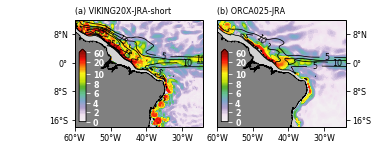

In [97]:
fig=plt.figure(figsize=(4.7,2.4))

ax1=fig.add_axes([0.1,0.1,0.38,0.8], projection=ccrs.PlateCarree())
ax2=fig.add_axes([0.52,0.1,0.38,0.8], projection=ccrs.PlateCarree())

################# VJs #################
ax1.set_extent([-60,-24,-18,12], crs=ccrs.PlateCarree())
ax1.add_feature(land)

ax1.contourf([-60,-24], [-18,12], np.zeros((2,2)), colors='lightgrey')
ct1 = ax1.contourf(ds_VJs.nav_lon, ds_VJs.nav_lat, speed_VJs*100, cmap=cm, levels=levels, norm=norm,
             extend='max')

c1 = ax1.contour(lon_EKE_VJs, lat_EKE_VJs, EKE_VJs, levels=np.arange(5,35,5), colors='k', linewidths=0.8)
plt.clabel(c1, fmt='%i', fontsize=8)

## ticks 
ax1.set_xticks(np.arange(-60,-22,10), crs = ccrs.PlateCarree())
ax1.set_yticks(np.arange(-16,13,8), crs = ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title('(a) VIKING20X-JRA-short', loc='left', fontsize=8)

## colorbar
ax1_cb=fig.add_axes([-0.1,0.22,0.25,0.42], frameon = False); 
ax1_cb.set_xticks([]); ax1_cb.set_yticks([])
ticks = [0, 2, 4, 6, 8, 10, 20, 60]
cb1 = plt.colorbar(ct1, ax=ax1_cb, aspect=10, ticks=ticks)
cb1.ax.yaxis.set_tick_params(color='w')
plt.setp(plt.getp(cb1.ax.axes, 'yticklabels'), color='w', fontweight='bold', fontsize=8);

################# OJ #################
ax2.set_extent([-60,-24,-18,12], crs=ccrs.PlateCarree())
ax2.add_feature(land)

ax2.contourf([-60,-24], [-18,12], np.zeros((2,2)), colors='lightgrey')
ct2 = ax2.contourf(fix_orca_longitude(ds_OJ.nav_lon[1:-1,1:-1]), ds_OJ.nav_lat[1:-1,1:-1], speed_OJ[1:-1,1:-1]*100, 
                   cmap=cm, levels=levels, norm=norm, extend='max')

c2 = ax2.contour(lon_EKE_OJ, lat_EKE_OJ, EKE_OJ, levels=np.arange(5,35,5), colors='k', linewidths=0.8)
plt.clabel(c2, fmt='%i', fontsize=8)

## ticks 
ax2.set_xticks(np.arange(-60,-22,10), crs = ccrs.PlateCarree())
ax2.set_yticks(np.arange(-16,13,8), crs = ccrs.PlateCarree())
ax2.yaxis.tick_right()
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('(b) ORCA025-JRA', loc='left', fontsize=8)

## colorbar
ax2_cb=fig.add_axes([0.32,0.22,0.25,0.42], frameon = False); 
ax2_cb.set_xticks([]); ax2_cb.set_yticks([])
ticks = [0, 2, 4, 6, 8, 10, 20, 60]
cb2 = plt.colorbar(ct2, ax=ax2_cb, aspect=10, ticks=ticks)
cb2.ax.yaxis.set_tick_params(color='w')
plt.setp(plt.getp(cb2.ax.axes, 'yticklabels'), color='w', fontweight='bold', fontsize=8);

#plt.savefig('figure15.png', dpi=150)

## Save data

In [98]:
# only store EKE as speed already saved for full Atlantic
EKE_VJs = EKE_VJs.rename({'y_c':'yVJs','x_c':'xVJs'})
EKE_VJs.attrs['long_name'] = 'Mean Eddy Kinetic Energy (0-1000 m)'
EKE_VJs.attrs['units'] = 'J/m^3'

lat_VJs = lat_EKE_VJs.rename({'x':'xVJs', 'y':'yVJs'}).rename('nav_latVJs')
lat_VJs.attrs['standard_name'] = 'latitude'
lat_VJs.attrs['long_name'] = 'Latitude'
lat_VJs.attrs['units'] = 'degrees_north'

lon_VJs = lon_EKE_VJs.rename({'x':'xVJs', 'y':'yVJs'}).rename('nav_lonVJs')
lon_VJs.attrs['standard_name'] = 'longitude'
lon_VJs.attrs['long_name'] = 'Longitude'
lon_VJs.attrs['units'] = 'degrees_east'

In [99]:
EKE_OJ = EKE_OJ.rename({'y_c':'yOJ','x_c':'xOJ'})
EKE_OJ.attrs['long_name'] = 'Mean Eddy Kinetic Energy (0-1000 m)'
EKE_OJ.attrs['units'] = 'J/m^3'

lat_OJ = lat_EKE_OJ.rename({'x':'xOJ', 'y':'yOJ'}).rename('nav_latOJ')
lat_OJ.attrs['standard_name'] = 'latitude'
lat_OJ.attrs['long_name'] = 'Latitude'
lat_OJ.attrs['units'] = 'degrees_north'

lon_OJ = lon_EKE_OJ.rename({'x':'xOJ', 'y':'yOJ'}).rename('nav_lonOJ')
lon_OJ.attrs['standard_name'] = 'longitude'
lon_OJ.attrs['long_name'] = 'Longitude'
lon_OJ.attrs['units'] = 'degrees_east'

In [100]:
VJs_speed = speed_VJs[1:-1,1:-1].rename({'x':'xVJs', 'y':'yVJs'})
VJs_speed.attrs['long_name'] = 'Average speed in density range 27.65 - 27.95 kg/m^3'
VJs_speed.attrs['units'] = 'm/s'

OJ_speed = speed_OJ[1:-1,1:-1].rename({'x':'xOJ', 'y':'yOJ'})
OJ_speed.attrs['long_name'] = 'Average speed in density range 27.65 - 27.95 kg/m^3'
OJ_speed.attrs['units'] = 'm/s'

In [105]:
dsout = xr.Dataset(data_vars = {'voekeVJs':EKE_VJs,
                                'voekeOJ':EKE_OJ,
                                'voocecurVJs':VJs_speed,
                                'voocecurOJ':OJ_speed,
                                'nav_latVJs':lat_VJs, 
                                'nav_lonVJs':lon_VJs,
                                'nav_latOJ':lat_OJ, 
                                'nav_lonOJ':lon_OJ
                               })

dsout.attrs['title'] = 'Mean (1990-2009) Eddy Kinetic Energy (0 - 1000m) and speed in sigma range'
dsout.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
dsout.attrs['creator_name'] = 'Tobias Schulzki'
dsout.attrs['creator_email'] = 'tschulzki@geomar.de'
dsout.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
dsout.attrs['license'] = 'CC BY 4.0'
dsout.attrs['keywords'] = 'Eddy Kinetic Energy, EKE, speed, density coordinates,  numerical model'
#dsout.attrs['summary'] = 'Created in python'


In [106]:
outpath='/gxfs_work1/geomar/smomw379/Publications/Biastoch2020/DATA/'
dsout.to_netcdf(outpath + 'data_figure15.nc')